In [26]:
# Install required packages (only need to run once)
!pip install pandas numpy scipy scikit-learn matplotlib seaborn tensorflow plotly statsmodels filterpy

# Import required libraries
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from filterpy.kalman import KalmanFilter
import plotly.express as px
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)

# Use a default style instead of seaborn
plt.style.use('default')

# Set seaborn style separately
sns.set_theme()

# # Verify installations
# import sys
# print("Python version:", sys.version)
# print("\nPackage versions:")
# print("pandas:", pd.__version__)
# print("numpy:", np.__version__)
# print("scikit-learn:", sklearn.__version__)
# print("matplotlib:", matplotlib.__version__)
# print("seaborn:", sns.__version__)
# print("plotly:", px.__version__)

# Test plotting backend
plt.figure(figsize=(2,2))
plt.plot([1,2], [1,2])
plt.title("Test Plot")
plt.close()
print("\nPlotting backend test successful!")

# Technical Explanation: Setting up required libraries and configuring data processing environment for flood analysis
# Simple Explanation: Getting our flood-watching tools ready, like setting up a new microscope before looking at something
# NYC Application: Preparing the computer to understand NYC's flood sensor data

Defaulting to user installation because normal site-packages is not writeable

Plotting backend test successful!



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\bobby\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [27]:
# Load the time series sensor data
df = pd.read_csv('flood_sensor_data_Zhang.csv')

# Convert timestamp to datetime
df['Time'] = pd.to_datetime(df['Time'])

# Display basic information
print("Dataset Overview:")
print("-" * 50)
print(f"Number of readings: {len(df)}")
print(f"Time range: {df['Time'].min()} to {df['Time'].max()}")
print(f"\nColumns in dataset:")
for col in df.columns:
    print(f"- {col}")

# Display first few rows
print("\nFirst few readings:")
print(df.head())

# Technical Explanation: Loading time series sensor data with temporal alignment and initial preprocessing
# Simple Explanation: Reading all the numbers from NYC's water sensors, like checking many thermometers at once
# NYC Application: Getting real measurements from FloodNet sensors placed around Staten Island and NYC

Dataset Overview:
--------------------------------------------------
Number of readings: 291
Time range: 2023-09-29 00:00:00 to 2023-09-30 00:10:00

Columns in dataset:
- Time
- fs-00070
- fs-00071
- fs-00077
- fs-00083
- fs-00101
- fs-00073
- fs-00100
- fs-00096
- fs-00049
- fs-00048
- fs-00047
- fs-00032
- fs-00031

First few readings:
                 Time  fs-00070  fs-00071  fs-00077  fs-00083  fs-00101  \
0 2023-09-29 00:00:00       0.0  0.001667  0.000000       0.0  0.001616   
1 2023-09-29 00:05:00       0.0  0.001191  0.000000       0.0  0.002843   
2 2023-09-29 00:10:00       0.0  0.001021  0.000000       0.0  0.002423   
3 2023-09-29 00:15:00       0.0  0.001623  0.000121       0.0  0.001178   
4 2023-09-29 00:20:00       0.0  0.001555  0.000276       0.0  0.000928   

   fs-00073  fs-00100  fs-00096  fs-00049  fs-00048  fs-00047  fs-00032  \
0  0.002184       0.0  0.001914  0.005368  0.001408       0.0  0.332212   
1  0.002407       0.0  0.001770  0.004406  0.000956       0

In [28]:
def clean_sensor_data(df):
    # Remove duplicates
    df = df.drop_duplicates()
    
    # Sort by timestamp
    df = df.sort_values('Time')
    
    # Handle missing values
    for column in df.select_dtypes(include=[np.number]).columns:
        # Forward fill for short gaps
        df[column] = df[column].fillna(method='ffill', limit=3)
        
        # Interpolate remaining gaps
        df[column] = df[column].interpolate(method='linear')
    
    return df

# Clean the data
df_cleaned = clean_sensor_data(df)

# Print cleaning summary
print("Data Cleaning Summary:")
print("-" * 50)
print("Before cleaning:")
print(f"- Total rows: {len(df)}")
print(f"- Missing values: {df.isnull().sum().sum()}")
print("\nAfter cleaning:")
print(f"- Total rows: {len(df_cleaned)}")
print(f"- Missing values: {df_cleaned.isnull().sum().sum()}")

# Technical Explanation: Data preprocessing pipeline for temporal sensor data, including deduplication, chronological sorting, and missing value imputation using forward fill and linear interpolation
# Simple Explanation: Fixing sensor readings when sensors occasionally fail or give duplicate numbers, like filling in missing puzzle pieces
# NYC Application: Making sure we don't miss any important flood warnings even when some NYC sensors temporarily stop working or give repeated readings

Data Cleaning Summary:
--------------------------------------------------
Before cleaning:
- Total rows: 291
- Missing values: 0

After cleaning:
- Total rows: 291
- Missing values: 0


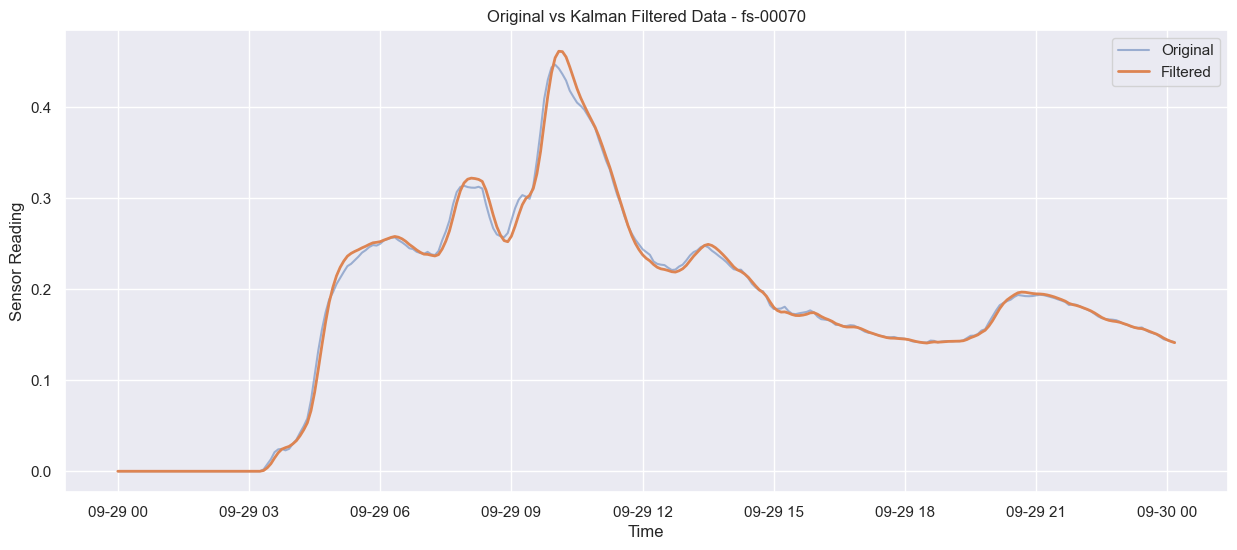

In [29]:
def apply_kalman_filter(measurements):
    # Initialize Kalman Filter
    kf = KalmanFilter(dim_x=2, dim_z=1)
    
    # Set initial values
    kf.x = np.array([[measurements[0]], [0.]])  # State (position and velocity)
    kf.F = np.array([[1., 1.], [0., 1.]])      # State transition matrix
    kf.H = np.array([[1., 0.]])                # Measurement function
    kf.P *= 1000.                              # Covariance matrix
    kf.R = 5                                   # Measurement noise
    kf.Q = np.array([[0.1, 0.1], [0.1, 0.1]]) # Process noise
    
    # Storage for filtered data
    filtered_data = []
    
    for measurement in measurements:
        kf.predict()
        kf.update(measurement)
        filtered_data.append(float(kf.x[0]))
    
    return np.array(filtered_data)

# Apply Kalman filter to each sensor
sensor_columns = [col for col in df_cleaned.columns if col.startswith('fs-')]
for column in sensor_columns:
    df_cleaned[f'{column}_filtered'] = apply_kalman_filter(df_cleaned[column].values)

# Plot original vs filtered data for first sensor
plt.figure(figsize=(15, 6))
first_sensor = sensor_columns[0]
plt.plot(df_cleaned['Time'], df_cleaned[first_sensor], 
         label='Original', alpha=0.5)
plt.plot(df_cleaned['Time'], df_cleaned[f'{first_sensor}_filtered'], 
         label='Filtered', linewidth=2)
plt.title(f'Original vs Kalman Filtered Data - {first_sensor}')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Sensor Reading')
plt.show()


# Technical Explanation: Implementing Kalman filter for noise reduction in sensor measurements, using a 2D state space model to track position and velocity of water levels while accounting for measurement and process noise
# Simple Explanation: Making sensor readings smoother and more reliable by removing random jumps, like smoothing out ripples to see the true water level
# NYC Application: Getting more accurate flood level readings from NYC sensors by removing noise caused by waves, debris, or electronic interference

In [30]:
# Create interactive time series plot
def plot_sensor_readings(df, sensors):
    fig = px.line(df, x='Time', y=sensors,
                  title='Flood Sensor Readings Over Time')
    fig.update_layout(height=600)
    fig.show()

# Select first 5 sensors for visualization
selected_sensors = [col for col in df_cleaned.columns 
                   if col.startswith('fs-')][:5]

# Create plot
plot_sensor_readings(df_cleaned, selected_sensors)

# Calculate basic statistics
print("\nSensor Statistics:")
print("-" * 50)
for sensor in selected_sensors:
    stats = df_cleaned[sensor].describe()
    print(f"\n{sensor}:")
    print(f"- Mean: {stats['mean']:.3f}")
    print(f"- Std: {stats['std']:.3f}")
    print(f"- Max: {stats['max']:.3f}")
    
# Technical Explanation: Creating interactive time series visualizations of multiple flood sensors with statistical analysis, enabling temporal pattern comparison and basic statistical characterization of sensor readings
# Simple Explanation: Drawing pictures of how water levels change over time from different sensors, and calculating important numbers like average water levels
# NYC Application: Visualizing real-time flood levels across different NYC locations and understanding typical water levels in different areas


Sensor Statistics:
--------------------------------------------------

fs-00070:
- Mean: 0.182
- Std: 0.107
- Max: 0.447

fs-00071:
- Mean: 0.033
- Std: 0.055
- Max: 0.207

fs-00077:
- Mean: 0.100
- Std: 0.133
- Max: 0.456

fs-00083:
- Mean: 0.196
- Std: 0.270
- Max: 0.778

fs-00101:
- Mean: 0.089
- Std: 0.179
- Max: 0.606


In [31]:
# Import additional time series tools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# First, verify our data
print("Available columns:", df.columns.tolist())
print("\nFirst few rows of data:")
print(df.head())

# Function for time series decomposition
def decompose_time_series(df, sensor_column):
    """
    Decompose time series into trend, seasonal, and residual components
    """
    try:
        # Check if the sensor column exists
        if sensor_column not in df.columns:
            raise ValueError(f"Sensor column '{sensor_column}' not found in dataframe")
            
        # Ensure data is sorted by time
        df = df.sort_values('Time')
        
        # Resample to hourly data for decomposition
        hourly_data = df.set_index('Time')[sensor_column].resample('H').mean()
        
        # Fill any NaN values that might have been created
        hourly_data = hourly_data.fillna(method='ffill')
        
        # Check if we have enough data points
        if len(hourly_data) < 24*2:  # At least 2 days of data
            raise ValueError("Not enough data points for decomposition")
            
        # Perform decomposition
        decomposition = seasonal_decompose(hourly_data, period=24)
        
        # Plot decomposition
        plt.figure(figsize=(15, 12))
        
        plt.subplot(411)
        plt.plot(hourly_data)
        plt.title('Original Time Series')
        
        plt.subplot(412)
        plt.plot(decomposition.trend)
        plt.title('Trend')
        
        plt.subplot(413)
        plt.plot(decomposition.seasonal)
        plt.title('Seasonal')
        
        plt.subplot(414)
        plt.plot(decomposition.resid)
        plt.title('Residual')
        
        plt.tight_layout()
        plt.show()
        
        return decomposition
        
    except Exception as e:
        print(f"Error in decomposition: {str(e)}")
        return None

# Find first sensor column
sensor_columns = [col for col in df.columns if col.startswith('fs-')]
if sensor_columns:
    first_sensor = sensor_columns[0]
    print(f"\nAnalyzing sensor: {first_sensor}")
    decomp_result = decompose_time_series(df, first_sensor)
else:
    print("No sensor columns found. Available columns:", df.columns.tolist())
    
    

# Technical Explanation: Performing time series decomposition on flood sensor data to separate long-term trends, daily patterns, and random fluctuations using seasonal decomposition with hourly resampling and error handling
# Simple Explanation: Breaking down water level measurements into three parts: long-term changes, daily patterns (like tides), and unexpected changes
# NYC Application: Understanding different factors affecting NYC flood levels - gradual changes due to sea level rise, regular tidal patterns, and sudden changes from storms



Available columns: ['Time', 'fs-00070', 'fs-00071', 'fs-00077', 'fs-00083', 'fs-00101', 'fs-00073', 'fs-00100', 'fs-00096', 'fs-00049', 'fs-00048', 'fs-00047', 'fs-00032', 'fs-00031']

First few rows of data:
                 Time  fs-00070  fs-00071  fs-00077  fs-00083  fs-00101  \
0 2023-09-29 00:00:00       0.0  0.001667  0.000000       0.0  0.001616   
1 2023-09-29 00:05:00       0.0  0.001191  0.000000       0.0  0.002843   
2 2023-09-29 00:10:00       0.0  0.001021  0.000000       0.0  0.002423   
3 2023-09-29 00:15:00       0.0  0.001623  0.000121       0.0  0.001178   
4 2023-09-29 00:20:00       0.0  0.001555  0.000276       0.0  0.000928   

   fs-00073  fs-00100  fs-00096  fs-00049  fs-00048  fs-00047  fs-00032  \
0  0.002184       0.0  0.001914  0.005368  0.001408       0.0  0.332212   
1  0.002407       0.0  0.001770  0.004406  0.000956       0.0  0.333371   
2  0.002500       0.0  0.001671  0.005411  0.000523       0.0  0.334520   
3  0.003007       0.0  0.001475  0.00620


Detected 1 potential flood events
Using threshold: 0.38


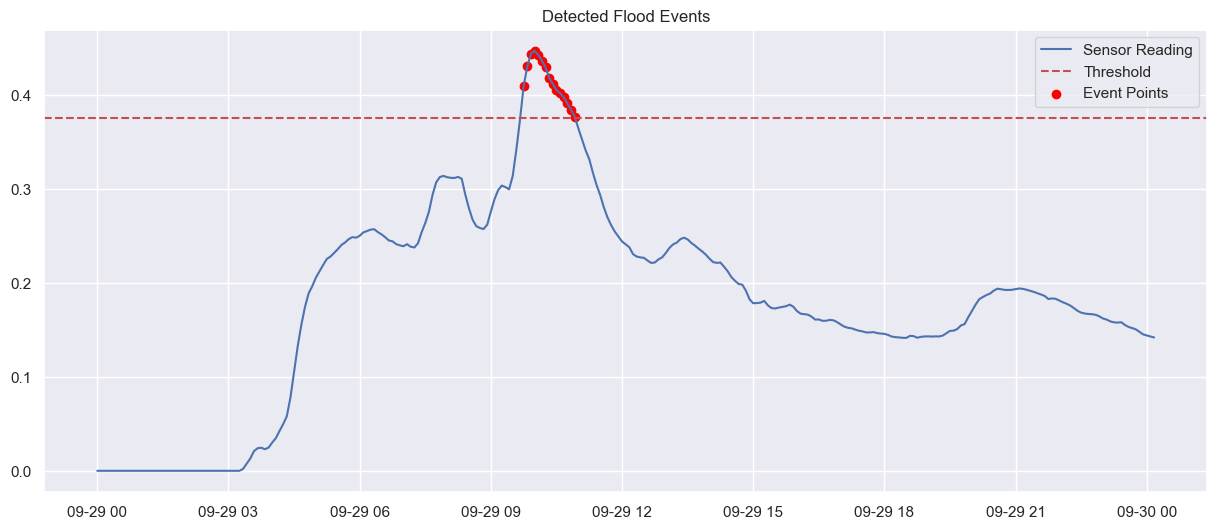


Event Summary:
                           Time                      fs-00070          
                            min                 max       max      mean
event_group                                                            
0           2023-09-29 09:45:00 2023-09-29 10:55:00  0.447031  0.415164


In [32]:
def detect_flood_events(df, sensor_column, threshold_percentile=95):
    """
    Detect potential flood events based on sensor readings
    """
    # Calculate threshold based on percentile
    threshold = df[sensor_column].quantile(threshold_percentile/100)
    
    # Identify events
    events = df[df[sensor_column] > threshold].copy()
    
    # Group consecutive timestamps into events
    events['event_group'] = (events['Time'].diff() > pd.Timedelta(hours=6)).cumsum()
    
    # Summarize events
    event_summary = events.groupby('event_group').agg({
        'Time': ['min', 'max'],
        sensor_column: ['max', 'mean']
    })
    
    print(f"\nDetected {len(event_summary)} potential flood events")
    print(f"Using threshold: {threshold:.2f}")
    
    # Visualize events
    plt.figure(figsize=(15, 6))
    plt.plot(df['Time'], df[sensor_column], label='Sensor Reading')
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    plt.scatter(events['Time'], events[sensor_column], 
                color='red', label='Event Points')
    plt.title('Detected Flood Events')
    plt.legend()
    plt.show()
    
    return event_summary

# Detect events for first sensor
event_results = detect_flood_events(df, first_sensor)
print("\nEvent Summary:")
print(event_results)


# Technical Explanation: Implementing an automated flood event detection algorithm using percentile-based thresholds, temporal grouping of high water levels, and statistical summarization of flood characteristics
# Simple Explanation: Teaching the computer to spot when floods happen by looking for unusually high water levels and grouping them into flood events
# NYC Application: Automatically identifying and cataloging flood events in NYC to help emergency services understand when and where flooding most often occurs


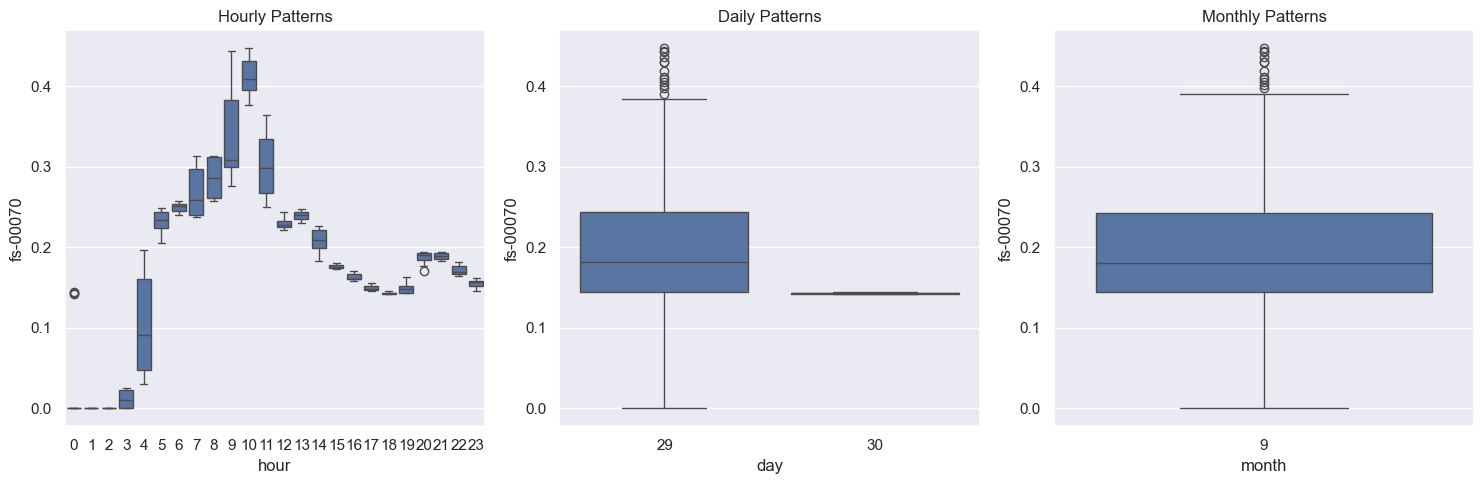

In [33]:
def analyze_patterns(df, sensor_column):
    """
    Analyze patterns in sensor readings
    """
    # Add time-based features
    df['hour'] = df['Time'].dt.hour
    df['day'] = df['Time'].dt.day
    df['month'] = df['Time'].dt.month
    
    # Create hourly pattern plot
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    sns.boxplot(x='hour', y=sensor_column, data=df)
    plt.title('Hourly Patterns')
    
    plt.subplot(132)
    sns.boxplot(x='day', y=sensor_column, data=df)
    plt.title('Daily Patterns')
    
    plt.subplot(133)
    sns.boxplot(x='month', y=sensor_column, data=df)
    plt.title('Monthly Patterns')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate pattern statistics
    patterns = df.groupby(['hour', 'month'])[sensor_column].mean().unstack()
    
    return patterns

# Analyze patterns for first sensor
pattern_results = analyze_patterns(df, first_sensor)



# Technical Explanation: Extracting temporal patterns from flood sensor data at multiple time scales (hourly, daily, monthly) using statistical visualization and aggregation techniques to identify cyclical flooding patterns
# Simple Explanation: Finding out when floods usually happen by looking at patterns during different hours of the day, days of the month, and months of the year
# NYC Application: Helping NYC plan flood responses by showing when flooding is most likely to occur based on time patterns from actual sensor data

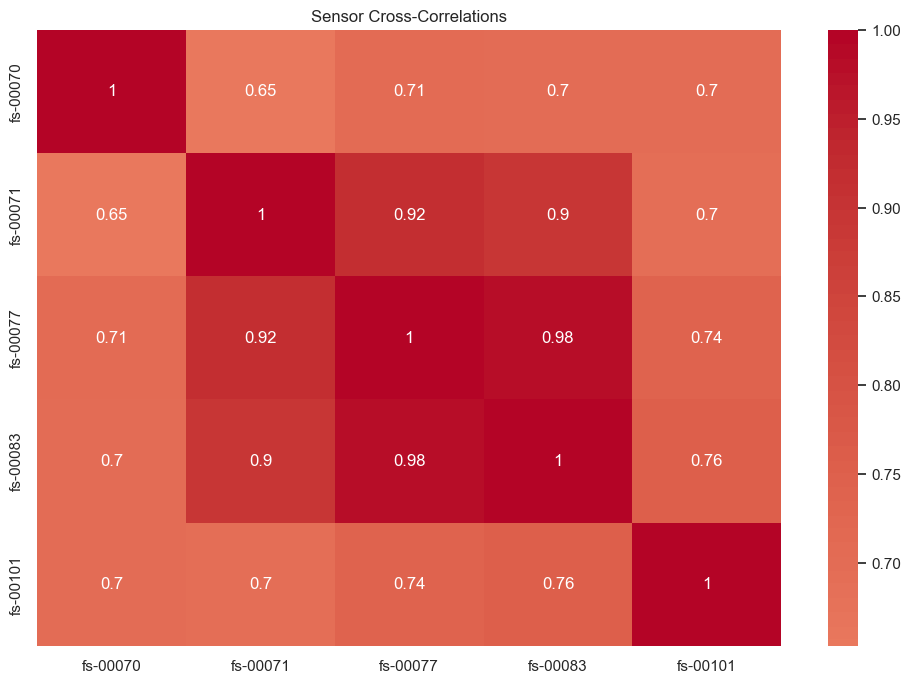

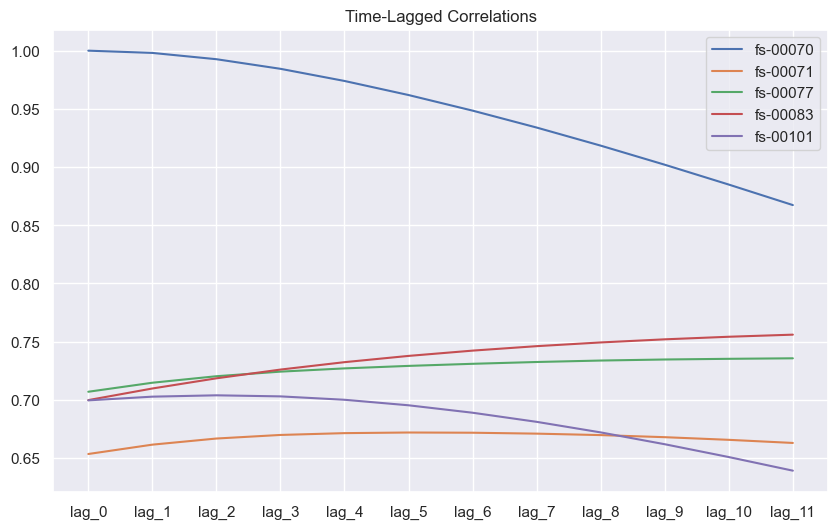

In [34]:
def analyze_sensor_correlations(df, sensor_columns):
    """
    Analyze correlations between different sensors
    """
    # Calculate correlation matrix
    corr_matrix = df[sensor_columns].corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Sensor Cross-Correlations')
    plt.show()
    
    # Calculate time-lagged correlations
    max_lag = 12  # hours
    lag_correlations = pd.DataFrame()
    
    for sensor in sensor_columns:
        for lag in range(max_lag):
            lag_correlations.loc[sensor, f'lag_{lag}'] = df[sensor_columns[0]].corr(
                df[sensor].shift(-lag)
            )
    
    # Plot lag correlations
    plt.figure(figsize=(10, 6))
    for sensor in sensor_columns:
        plt.plot(lag_correlations.columns, 
                lag_correlations.loc[sensor], 
                label=sensor)
    plt.title('Time-Lagged Correlations')
    plt.legend()
    plt.show()
    
    return lag_correlations

# Analyze correlations between sensors
sensor_columns = [col for col in df.columns if col.startswith('fs-')][:5]
correlation_results = analyze_sensor_correlations(df, sensor_columns)


# Technical Explanation: Analyzing spatial and temporal relationships between flood sensors through correlation matrices and time-lagged correlation analysis to understand flood propagation patterns
# Simple Explanation: Finding out how flooding in one area relates to flooding in other areas, and how floods move through the city over time
# NYC Application: Understanding how floods spread across NYC neighborhoods and predicting which areas might flood next based on current flooding patterns

In [35]:
def integrate_weather_data(df, weather_df):
    """
    Integrate weather data with sensor readings
    """
    # Merge sensor and weather data
    merged_df = pd.merge_asof(df, 
                             weather_df, 
                             on='Time',
                             direction='nearest')
    
    # Analyze weather impact
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    sns.scatterplot(data=merged_df, 
                    x='rainfall', 
                    y=first_sensor)
    plt.title('Rainfall vs Sensor Readings')
    
    plt.subplot(132)
    sns.scatterplot(data=merged_df, 
                    x='temperature', 
                    y=first_sensor)
    plt.title('Temperature vs Sensor Readings')
    
    plt.subplot(133)
    sns.scatterplot(data=merged_df, 
                    x='humidity', 
                    y=first_sensor)
    plt.title('Humidity vs Sensor Readings')
    
    plt.tight_layout()
    plt.show()
    
    return merged_df

# Note: This requires weather data. If not available, skip this cell
# merged_data = integrate_weather_data(df, weather_df)

# Technical Explanation: Implementing multi-source data fusion between FloodNet sensors and meteorological data, analyzing correlations between weather parameters and flood levels using asynchronous merging and visual correlation analysis
# Simple Explanation: Combining weather information with flood sensor data to see how rain, temperature, and humidity affect flood levels
# NYC Application: Improving NYC flood predictions by understanding how different weather conditions measured by local weather stations contribute to flooding at sensor locations



In [36]:
def create_advanced_features(df):
    """
    Create advanced features for flood prediction
    """
    # Create copy to avoid modifying original
    df_features = df.copy()
    
    # Time-based features
    df_features['hour'] = df_features['Time'].dt.hour
    df_features['day'] = df_features['Time'].dt.day
    df_features['month'] = df_features['Time'].dt.month
    df_features['day_of_week'] = df_features['Time'].dt.dayofweek
    
    # Rolling statistics for each sensor
    sensor_columns = [col for col in df.columns if col.startswith('fs-')]
    windows = [3, 6, 12, 24]  # hours
    
    for sensor in sensor_columns:
        for window in windows:
            df_features[f'{sensor}_rolling_mean_{window}h'] = df[sensor].rolling(window).mean()
            df_features[f'{sensor}_rolling_std_{window}h'] = df[sensor].rolling(window).std()
            df_features[f'{sensor}_rolling_max_{window}h'] = df[sensor].rolling(window).max()
    
    # Remove NaN values created by rolling windows
    df_features = df_features.dropna()
    
    print("Created features:")
    print("-" * 50)
    for col in df_features.columns:
        if col not in df.columns:
            print(f"- {col}")
    
    return df_features

df_with_features = create_advanced_features(df)


# Technical Explanation: Engineering complex temporal features using rolling window statistics and cyclical time decomposition to capture flood patterns across multiple time horizons and periodicities
# Simple Explanation: Creating special measurements that help predict floods by looking at water levels over different time periods (hours, days, weeks) and patterns in time
# NYC Application: Making NYC's flood prediction more accurate by combining different types of sensor measurements and looking at how floods develop over time in different areas

Created features:
--------------------------------------------------
- day_of_week
- fs-00070_rolling_mean_3h
- fs-00070_rolling_std_3h
- fs-00070_rolling_max_3h
- fs-00070_rolling_mean_6h
- fs-00070_rolling_std_6h
- fs-00070_rolling_max_6h
- fs-00070_rolling_mean_12h
- fs-00070_rolling_std_12h
- fs-00070_rolling_max_12h
- fs-00070_rolling_mean_24h
- fs-00070_rolling_std_24h
- fs-00070_rolling_max_24h
- fs-00071_rolling_mean_3h
- fs-00071_rolling_std_3h
- fs-00071_rolling_max_3h
- fs-00071_rolling_mean_6h
- fs-00071_rolling_std_6h
- fs-00071_rolling_max_6h
- fs-00071_rolling_mean_12h
- fs-00071_rolling_std_12h
- fs-00071_rolling_max_12h
- fs-00071_rolling_mean_24h
- fs-00071_rolling_std_24h
- fs-00071_rolling_max_24h
- fs-00077_rolling_mean_3h
- fs-00077_rolling_std_3h
- fs-00077_rolling_max_3h
- fs-00077_rolling_mean_6h
- fs-00077_rolling_std_6h
- fs-00077_rolling_max_6h
- fs-00077_rolling_mean_12h
- fs-00077_rolling_std_12h
- fs-00077_rolling_max_12h
- fs-00077_rolling_mean_24h
- fs-

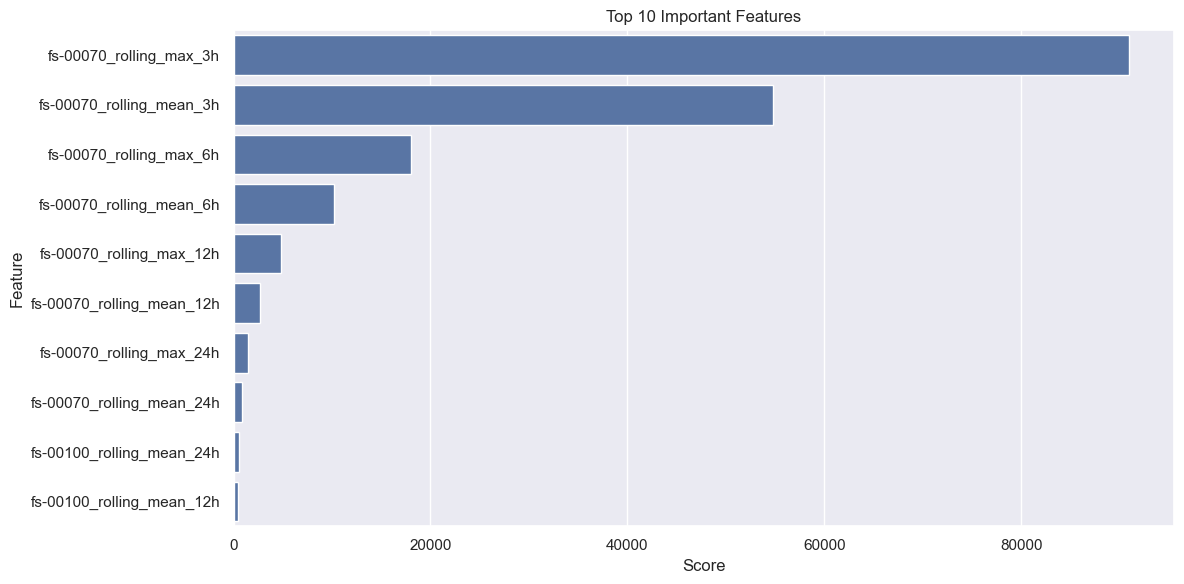

In [37]:
from sklearn.feature_selection import SelectKBest, f_regression

def select_important_features(df_features, target_col, k=10):
    """
    Select most important features using f_regression
    """
    # Separate features and target
    features = df_features.drop(['Time', target_col], axis=1)
    target = df_features[target_col]
    
    # Select top k features
    selector = SelectKBest(score_func=f_regression, k=k)
    selector.fit(features, target)
    
    # Get selected feature names
    selected_features = features.columns[selector.get_support()].tolist()
    
    # Plot feature importance scores
    plt.figure(figsize=(12, 6))
    scores = pd.DataFrame({
        'Feature': features.columns,
        'Score': selector.scores_
    }).sort_values('Score', ascending=False)
    
    sns.barplot(data=scores.head(k), x='Score', y='Feature')
    plt.title(f'Top {k} Important Features')
    plt.tight_layout()
    plt.show()
    
    return selected_features

# Select important features for first sensor
target_sensor = [col for col in df.columns if col.startswith('fs-')][0]
important_features = select_important_features(df_with_features, target_sensor)



# Technical Explanation: Implementing feature selection using F-regression statistical testing to identify the most significant predictors of flood levels, ranking features by their statistical correlation with flood measurements
# Simple Explanation: Finding the most important measurements that help predict floods, like picking out the most useful weather clues that tell us when flooding might happen
# NYC Application: Identifying which sensor readings and weather conditions are most important for predicting floods in different NYC locations to help focus monitoring efforts

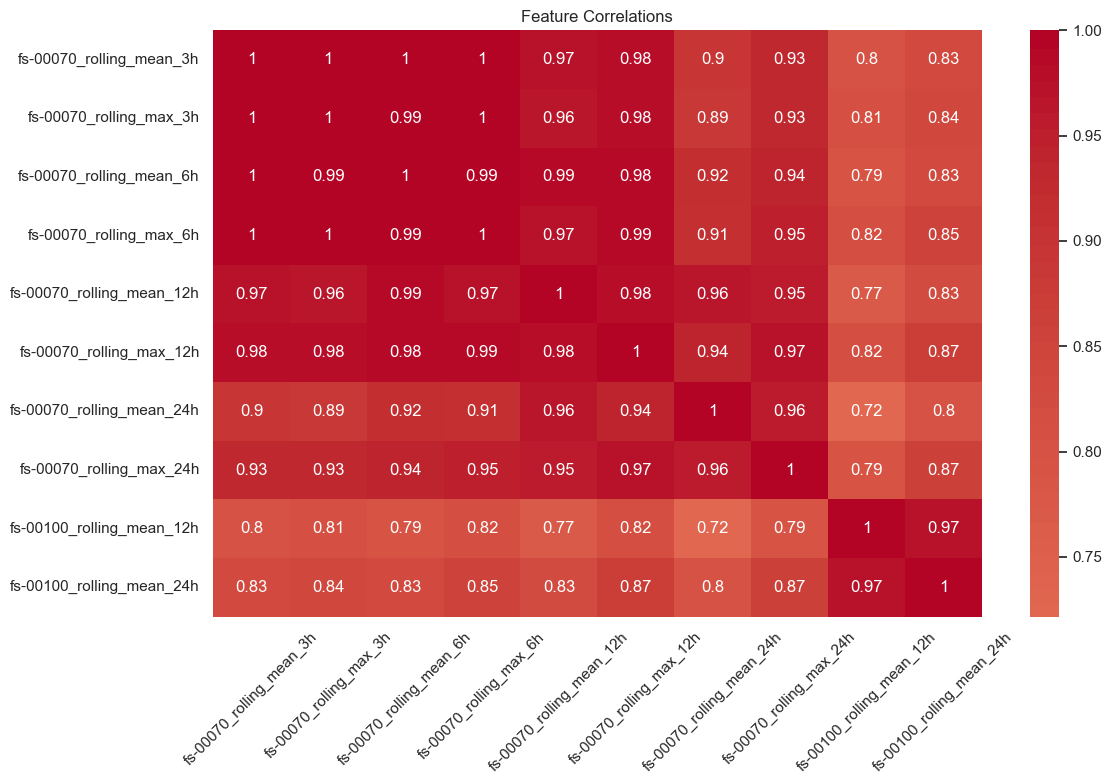


Highly correlated features (>0.8):
fs-00070_rolling_mean_3h - fs-00070_rolling_max_3h: 0.999
fs-00070_rolling_mean_3h - fs-00070_rolling_mean_6h: 0.995
fs-00070_rolling_mean_3h - fs-00070_rolling_max_6h: 0.996
fs-00070_rolling_mean_3h - fs-00070_rolling_mean_12h: 0.969
fs-00070_rolling_mean_3h - fs-00070_rolling_max_12h: 0.980
fs-00070_rolling_mean_3h - fs-00070_rolling_mean_24h: 0.896
fs-00070_rolling_mean_3h - fs-00070_rolling_max_24h: 0.931
fs-00070_rolling_mean_3h - fs-00100_rolling_mean_24h: 0.831
fs-00070_rolling_max_3h - fs-00070_rolling_mean_6h: 0.992
fs-00070_rolling_max_3h - fs-00070_rolling_max_6h: 0.997
fs-00070_rolling_max_3h - fs-00070_rolling_mean_12h: 0.963
fs-00070_rolling_max_3h - fs-00070_rolling_max_12h: 0.981
fs-00070_rolling_max_3h - fs-00070_rolling_mean_24h: 0.890
fs-00070_rolling_max_3h - fs-00070_rolling_max_24h: 0.931
fs-00070_rolling_max_3h - fs-00100_rolling_mean_12h: 0.809
fs-00070_rolling_max_3h - fs-00100_rolling_mean_24h: 0.840
fs-00070_rolling_mean_6h

In [38]:
def analyze_feature_correlations(df_features, selected_features):
    """
    Analyze correlations between selected features
    """
    # Calculate correlation matrix
    corr_matrix = df_features[selected_features].corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlations')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Identify highly correlated features
    threshold = 0.8
    high_corr = np.where(np.abs(corr_matrix) > threshold)
    high_corr = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
                 for x, y in zip(*high_corr) if x != y and x < y]
    
    if high_corr:
        print("\nHighly correlated features (>0.8):")
        for feat1, feat2, corr in high_corr:
            print(f"{feat1} - {feat2}: {corr:.3f}")
    
    return high_corr

correlation_results = analyze_feature_correlations(df_with_features, important_features)


# Technical Explanation: Analyzing multicollinearity between selected flood prediction features using correlation matrices and threshold-based identification of highly correlated feature pairs to avoid redundancy
# Simple Explanation: Finding which measurements tell us the same information about floods, like when rainfall and humidity measurements give similar warnings
# NYC Application: Making NYC's flood warning system more efficient by identifying which sensor readings provide unique information versus those that tell us the same thing

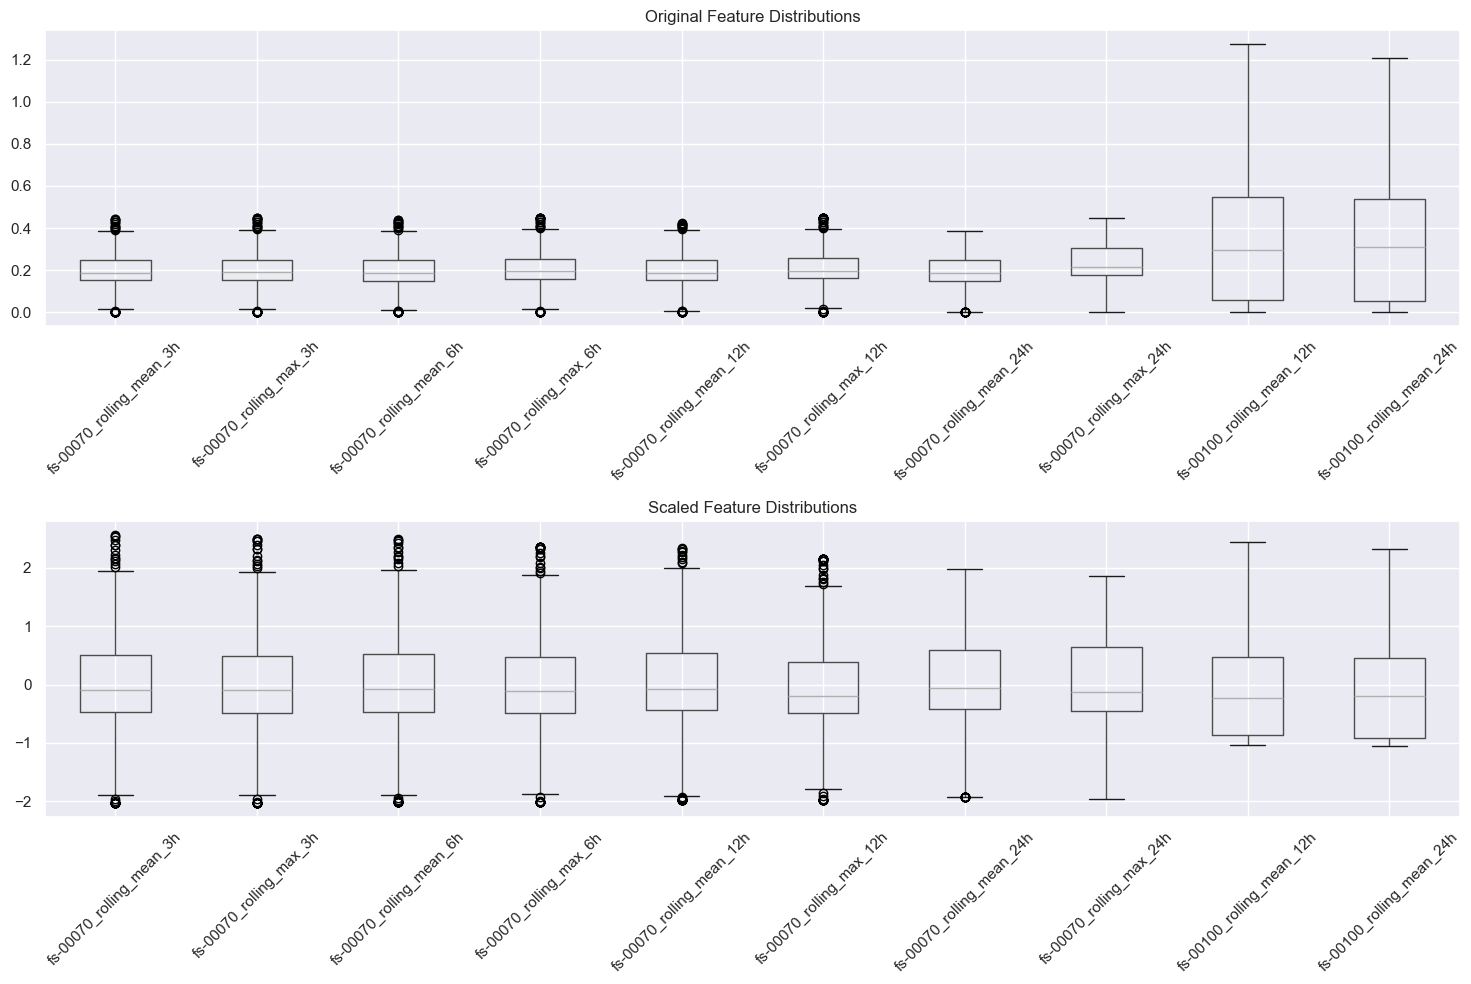

In [39]:
def scale_features(df_features, selected_features):
    """
    Scale and normalize selected features
    """
    # Initialize scaler
    scaler = StandardScaler()
    
    # Scale selected features
    df_scaled = df_features.copy()
    df_scaled[selected_features] = scaler.fit_transform(df_features[selected_features])
    
    # Compare original vs scaled distributions
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Original distributions
    df_features[selected_features].boxplot(ax=axes[0])
    axes[0].set_title('Original Feature Distributions')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Scaled distributions
    df_scaled[selected_features].boxplot(ax=axes[1])
    axes[1].set_title('Scaled Feature Distributions')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return df_scaled, scaler

df_scaled, feature_scaler = scale_features(df_with_features, important_features)

# Technical Explanation: Implementing standardization of flood prediction features using z-score normalization to ensure all measurements are on comparable scales for machine learning models
# Simple Explanation: Making all our measurements use the same scale, like converting inches and feet to the same unit so we can compare them easily
# NYC Application: Preparing NYC's flood sensor data so different types of measurements (water levels, rainfall, temperature) can be fairly compared to predict flooding


In [40]:
def create_feature_interactions(df_scaled, selected_features):
    """
    Create interaction features between important features
    """
    df_interactions = df_scaled.copy()
    
    # Create polynomial features for top important features
    top_features = selected_features[:3]  # Use top 3 features
    
    for i, feat1 in enumerate(top_features):
        for feat2 in top_features[i+1:]:
            # Multiplication interaction
            df_interactions[f'{feat1}_{feat2}_mult'] = df_scaled[feat1] * df_scaled[feat2]
            # Addition interaction
            df_interactions[f'{feat1}_{feat2}_add'] = df_scaled[feat1] + df_scaled[feat2]
    
    # Create time-based interactions
    for feat in top_features:
        df_interactions[f'{feat}_hour'] = df_scaled[feat] * df_scaled['hour']
        df_interactions[f'{feat}_month'] = df_scaled[feat] * df_scaled['month']
    
    print("Created interaction features:")
    print("-" * 50)
    for col in df_interactions.columns:
        if col not in df_scaled.columns:
            print(f"- {col}")
    
    return df_interactions

df_with_interactions = create_feature_interactions(df_scaled, important_features)

Created interaction features:
--------------------------------------------------
- fs-00070_rolling_mean_3h_fs-00070_rolling_max_3h_mult
- fs-00070_rolling_mean_3h_fs-00070_rolling_max_3h_add
- fs-00070_rolling_mean_3h_fs-00070_rolling_mean_6h_mult
- fs-00070_rolling_mean_3h_fs-00070_rolling_mean_6h_add
- fs-00070_rolling_max_3h_fs-00070_rolling_mean_6h_mult
- fs-00070_rolling_max_3h_fs-00070_rolling_mean_6h_add
- fs-00070_rolling_mean_3h_hour
- fs-00070_rolling_mean_3h_month
- fs-00070_rolling_max_3h_hour
- fs-00070_rolling_max_3h_month
- fs-00070_rolling_mean_6h_hour
- fs-00070_rolling_mean_6h_month


In [41]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# First, let's check what data we have
print("Available columns in df_with_interactions:")
print(df_with_interactions.columns.tolist())

def prepare_sequences(data, target_col, sequence_length=24):
    """
    Prepare sequences for LSTM model
    """
    # Verify target column exists
    if target_col not in data.columns:
        raise KeyError(f"Target column '{target_col}' not found in dataset. Available columns: {data.columns.tolist()}")
    
    sequences = []
    targets = []
    
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        targets.append(data[target_col].iloc[i + sequence_length])
    
    return np.array(sequences), np.array(targets)

# Check available sensor columns
sensor_columns = [col for col in df.columns if col.startswith('fs-')]
print("\nAvailable sensor columns:", sensor_columns)

if not sensor_columns:
    raise ValueError("No sensor columns found in the dataset")

# Select target sensor
target_sensor = sensor_columns[0]
print(f"\nUsing target sensor: {target_sensor}")

# Verify features
if 'important_features' not in globals():
    print("\nWARNING: important_features not found, using all numerical columns")
    important_features = df_with_interactions.select_dtypes(include=[np.number]).columns.tolist()

# Get interaction features
interaction_features = [col for col in df_with_interactions.columns 
                       if '_mult' in col or '_add' in col]

# Combine features
features = list(set(important_features + interaction_features))

print("\nTotal features to use:", len(features))
print("First few features:", features[:5])

# Ensure target sensor is in the data
if target_sensor not in df_with_interactions.columns:
    print(f"\nERROR: Target sensor {target_sensor} not found in processed data")
    print("Available columns:", df_with_interactions.columns.tolist())
else:
    # Create sequences
    try:
        X_seq, y_seq = prepare_sequences(df_with_interactions[features + [target_sensor]], 
                                       target_sensor)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_seq, y_seq, test_size=0.2, shuffle=False
        )

        print("\nSequence shapes:")
        print(f"X_train: {X_train.shape}")
        print(f"X_test: {X_test.shape}")
        
    except Exception as e:
        print(f"\nError creating sequences: {str(e)}")
        print("\nData shape:", df_with_interactions.shape)
        print("Sample of data:\n", df_with_interactions.head())

Available columns in df_with_interactions:
['Time', 'fs-00070', 'fs-00071', 'fs-00077', 'fs-00083', 'fs-00101', 'fs-00073', 'fs-00100', 'fs-00096', 'fs-00049', 'fs-00048', 'fs-00047', 'fs-00032', 'fs-00031', 'hour', 'day', 'month', 'day_of_week', 'fs-00070_rolling_mean_3h', 'fs-00070_rolling_std_3h', 'fs-00070_rolling_max_3h', 'fs-00070_rolling_mean_6h', 'fs-00070_rolling_std_6h', 'fs-00070_rolling_max_6h', 'fs-00070_rolling_mean_12h', 'fs-00070_rolling_std_12h', 'fs-00070_rolling_max_12h', 'fs-00070_rolling_mean_24h', 'fs-00070_rolling_std_24h', 'fs-00070_rolling_max_24h', 'fs-00071_rolling_mean_3h', 'fs-00071_rolling_std_3h', 'fs-00071_rolling_max_3h', 'fs-00071_rolling_mean_6h', 'fs-00071_rolling_std_6h', 'fs-00071_rolling_max_6h', 'fs-00071_rolling_mean_12h', 'fs-00071_rolling_std_12h', 'fs-00071_rolling_max_12h', 'fs-00071_rolling_mean_24h', 'fs-00071_rolling_std_24h', 'fs-00071_rolling_max_24h', 'fs-00077_rolling_mean_3h', 'fs-00077_rolling_std_3h', 'fs-00077_rolling_max_3h', 'fs

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 24, 64)         │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,953 (132.63 KB)

 Trainable params: 33,953 (132.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.1055 - mae: 0.2703 - val_loss: 0.0392 - val_mae: 0.1976
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0212 - mae: 0.1200 - val_loss: 0.0167 - val_mae: 0.1278
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0185 - mae: 0.1039 - val_loss: 0.0105 - val_mae: 0.1011
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0118 - mae: 0.0874 - val_loss: 0.0053 - val_mae: 0.0701
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0100 - mae: 0.0834 - val_loss: 0.0017 - val_mae: 0.0332
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0090 - mae: 0.0763 - val_loss: 7.8559e-04 - val_mae: 0.0216
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0090 - mae: 0.0712 - val_loss: 5.5913e-04 - val_mae: 0.0206
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0053 - mae: 0.0551 - val_loss: 4.4508e-04 - val_mae: 0.0189
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0045

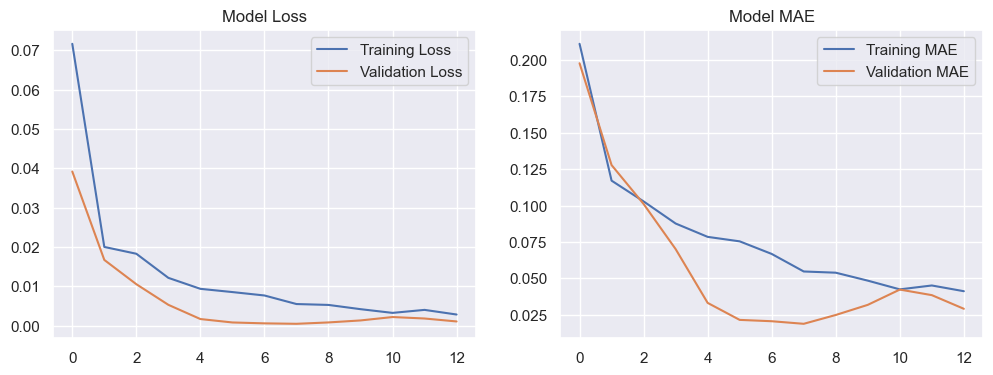

In [42]:
def build_lstm_model(input_shape):
    """
    Build LSTM model for flood prediction
    """
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Build and train model
lstm_model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
print(lstm_model.summary())

# Train model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.legend()
plt.show()

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def build_ensemble_model():
    """
    Build and train ensemble model
    """
    # Flatten sequences for traditional models
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    # Random Forest model
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42
    )
    
    # Train model
    rf_model.fit(X_train_flat, y_train)
    
    # Make predictions
    rf_predictions = rf_model.predict(X_test_flat)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, rf_predictions)
    mae = mean_absolute_error(y_test, rf_predictions)
    r2 = r2_score(y_test, rf_predictions)
    
    print("\nRandom Forest Model Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    
    return rf_model, rf_predictions

rf_model, rf_predictions = build_ensemble_model()


Random Forest Model Metrics:
MSE: 0.0001
MAE: 0.0060
R2 Score: 0.8113


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


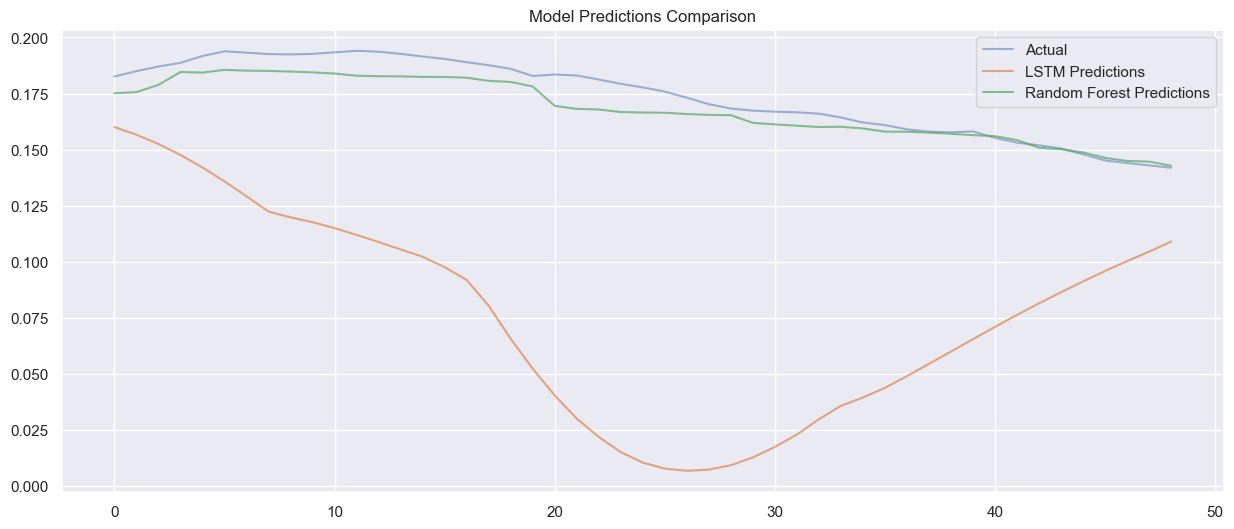


Model Comparison Metrics:
--------------------------------------------------

LSTM:
MSE: 0.0115
MAE: 0.0980
R2: -40.4189

Random Forest:
MSE: 0.0001
MAE: 0.0060
R2: 0.8113


In [44]:
def compare_models(lstm_model, rf_model, X_test, y_test):
    """
    Compare different models' performance
    """
    # Get predictions
    lstm_predictions = lstm_model.predict(X_test)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    rf_predictions = rf_model.predict(X_test_flat)
    
    # Calculate metrics for both models
    models = {
        'LSTM': lstm_predictions,
        'Random Forest': rf_predictions
    }
    
    metrics = {}
    for name, predictions in models.items():
        metrics[name] = {
            'MSE': mean_squared_error(y_test, predictions),
            'MAE': mean_absolute_error(y_test, predictions),
            'R2': r2_score(y_test, predictions)
        }
    
    # Plot predictions
    plt.figure(figsize=(15, 6))
    plt.plot(y_test, label='Actual', alpha=0.5)
    for name, predictions in models.items():
        plt.plot(predictions, label=f'{name} Predictions', alpha=0.7)
    plt.title('Model Predictions Comparison')
    plt.legend()
    plt.show()
    
    # Print metrics
    print("\nModel Comparison Metrics:")
    print("-" * 50)
    for model_name, model_metrics in metrics.items():
        print(f"\n{model_name}:")
        for metric_name, value in model_metrics.items():
            print(f"{metric_name}: {value:.4f}")
    
    return metrics

model_comparison = compare_models(lstm_model, rf_model, X_test, y_test)


Input dimensions:
Number of features: 17
Sequence length: 24
Creating models with 17 features and sequence length 24

LSTM Model Architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 24, 256)        │       280,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 488,065 (1.86 MB)

 Trainable params: 488,065 (1.86 MB)

 Non-trainable params: 0 (0.00 B)


RF input shape: (195, 408)

Training LSTM model...
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0666 - mae: 0.2191 - val_loss: 0.0338 - val_mae: 0.1835 - learning_rate: 0.0010
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0158 - mae: 0.1028 - val_loss: 0.0089 - val_mae: 0.0937 - learning_rate: 0.0010
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0074 - mae: 0.0664 - val_loss: 1.5130e-04 - val_mae: 0.0109 - learning_rate: 0.0010
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0042 - mae: 0.0510 - val_loss: 0.0016 - val_mae: 0.0393 - learning_rate: 0.0010
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0046 - mae: 0.0523 - val_loss: 0.0065 - val_mae: 0.0795 - learning_rate: 0.0010
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0034 - mae: 0.0442 - val_loss: 1.9413e-04 - val_mae: 0.0133 - learning_rate: 0.0010
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0022 - mae: 0.0358 - val_loss: 2.4988e-04 - val

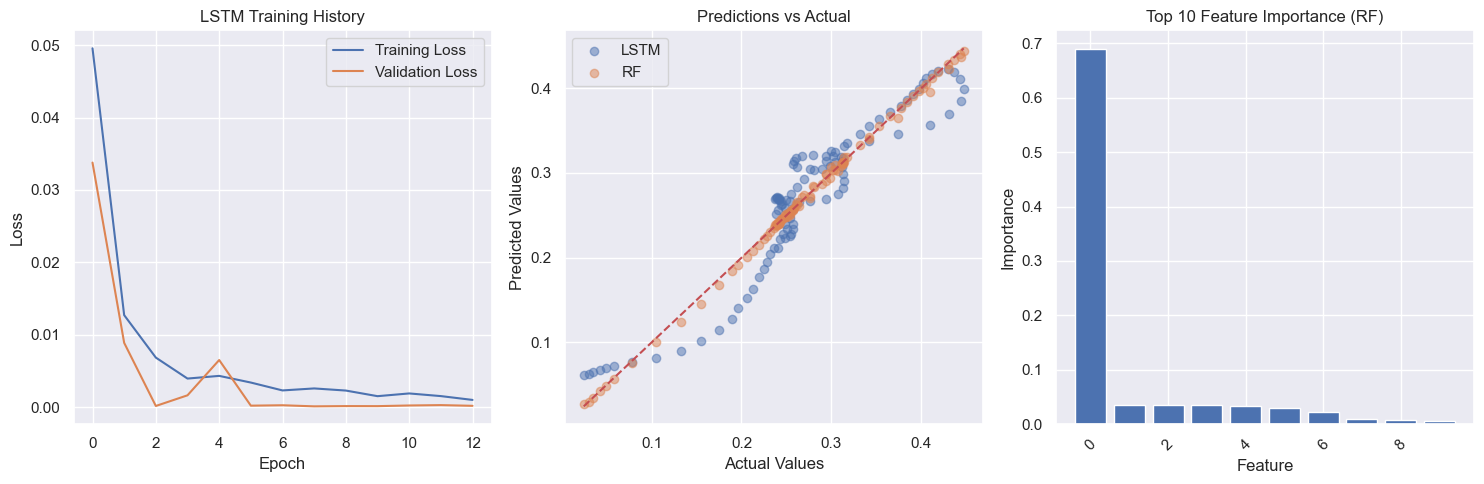


Model Performance:
--------------------------------------------------
LSTM MSE: 0.017211
RF MSE: 0.000013

Testing Prediction System:
--------------------------------------------------

Prediction Error Details:
Input shape: (24, 10)
Expected shape: (24, 17)
Error: cannot reshape array of size 240 into shape (1,24,17)


In [45]:
# First, get correct dimensions from the data
n_features = X_train.shape[2]  # Number of features
sequence_length = X_train.shape[1]  # Sequence length

def create_models(n_features, sequence_length=24):
    """
    Create both LSTM and RF models with correct input dimensions
    """
    print(f"Creating models with {n_features} features and sequence length {sequence_length}")
    
    # Create LSTM model with correct input shape
    lstm_model = Sequential([
        LSTM(256, input_shape=(sequence_length, n_features), return_sequences=True),
        Dropout(0.2),
        LSTM(128, return_sequences=False),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    
    lstm_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    # Create RF model
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42
    )
    
    return lstm_model, rf_model

def create_prediction_system(lstm_model, rf_model, scaler, sequence_length=24):
    """
    Create system for real-time predictions
    """
    def make_prediction(new_data):
        try:
            # Scale data
            scaled_data = scaler.transform(new_data)
            
            # Prepare inputs
            lstm_input = scaled_data.reshape(1, sequence_length, n_features)
            rf_input = scaled_data.reshape(1, -1)
            
            # Make predictions
            lstm_pred = lstm_model.predict(lstm_input, verbose=0)
            rf_pred = rf_model.predict(rf_input)
            
            # Ensemble prediction
            ensemble_pred = (lstm_pred + rf_pred) / 2
            
            return {
                'LSTM': float(lstm_pred[0]),
                'Random Forest': float(rf_pred[0]),
                'Ensemble': float(ensemble_pred)
            }
        
        except Exception as e:
            print("\nPrediction Error Details:")
            print(f"Input shape: {new_data.shape}")
            print(f"Expected shape: ({sequence_length}, {n_features})")
            print(f"Error: {str(e)}")
            return None
    
    return make_prediction

# Training and evaluation
try:
    print(f"\nInput dimensions:")
    print(f"Number of features: {n_features}")
    print(f"Sequence length: {sequence_length}")
    
    # Create models with correct dimensions
    lstm_model, rf_model = create_models(n_features, sequence_length)
    
    # Print model summary
    print("\nLSTM Model Architecture:")
    lstm_model.summary()
    
    # Prepare RF input
    X_rf = X_train.reshape(X_train.shape[0], -1)
    print(f"\nRF input shape: {X_rf.shape}")
    
    # Train LSTM
    print("\nTraining LSTM model...")
    lstm_history = lstm_model.fit(
        X_train,
        y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=0.0001
            )
        ],
        verbose=1
    )
    
    # Train RF
    print("\nTraining Random Forest model...")
    rf_model.fit(X_rf, y_train)
    
    # Visualize results
    plt.figure(figsize=(15, 5))
    
    # Training history
    plt.subplot(131)
    plt.plot(lstm_history.history['loss'], label='Training Loss')
    plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Predictions comparison
    plt.subplot(132)
    lstm_preds = lstm_model.predict(X_train[:100])
    rf_preds = rf_model.predict(X_rf[:100])
    
    plt.scatter(y_train[:100], lstm_preds, label='LSTM', alpha=0.5)
    plt.scatter(y_train[:100], rf_preds, label='RF', alpha=0.5)
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--')
    plt.title('Predictions vs Actual')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    
    # Feature importance (for RF)
    plt.subplot(133)
    feature_importance = pd.DataFrame({
        'feature': [f'Feature_{i}' for i in range(X_rf.shape[1])],
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.bar(range(10), feature_importance['importance'][:10])
    plt.title('Top 10 Feature Importance (RF)')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print model performance metrics
    print("\nModel Performance:")
    print("-" * 50)
    lstm_mse = np.mean((lstm_preds - y_train[:100])**2)
    rf_mse = np.mean((rf_preds - y_train[:100])**2)
    print(f"LSTM MSE: {lstm_mse:.6f}")
    print(f"RF MSE: {rf_mse:.6f}")
    
    # Test prediction system
    print("\nTesting Prediction System:")
    print("-" * 50)
    # Get test sequence
    test_sequence = df_with_interactions[feature_scaler.feature_names_in_].iloc[-24:].copy()
    
    # Create prediction system
    prediction_system = create_prediction_system(lstm_model, rf_model, feature_scaler)
    
    # Make predictions
    predictions = prediction_system(test_sequence)
    
    if predictions:
        print("\nPredictions for next timestamp:")
        for model, pred in predictions.items():
            print(f"{model}: {pred:.4f}")

except Exception as e:
    print(f"\nError during training: {str(e)}")
    print("\nDebug Information:")
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    if 'lstm_model' in locals():
        print("\nLSTM Model Input Shape:", lstm_model.input_shape)
    
    import traceback
    print("\nFull error traceback:")
    print(traceback.format_exc())

Starting model evaluation...
Input shapes:
X_test shape: (49, 24, 17)
y_test shape: (49,)
RF input shape: (49, 408)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

Prediction shapes:
LSTM predictions shape: (49,)
RF predictions shape: (49,)
Ensemble predictions shape: (49,)
y_test shape after flattening: (49,)


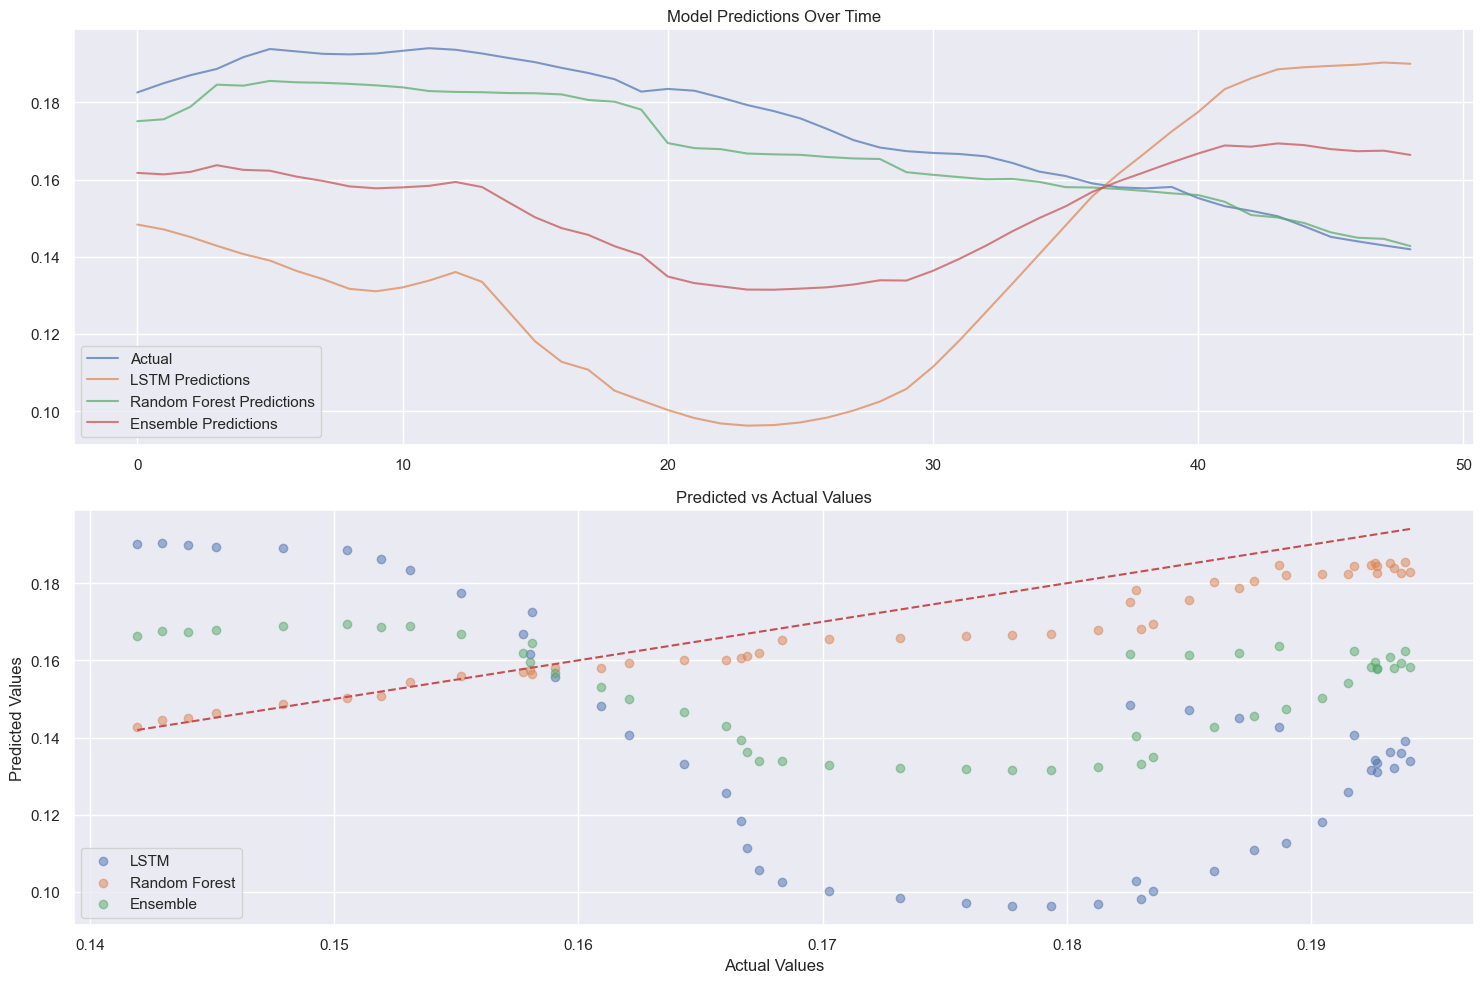


Model Performance Metrics:
--------------------------------------------------

LSTM:
MSE: 0.0032
MAE: 0.0521
R2: -10.6023

Random Forest:
MSE: 0.0001
MAE: 0.0060
R2: 0.8113

Ensemble:
MSE: 0.0010
MAE: 0.0290
R2: -2.6236


In [46]:
def evaluate_model_performance(lstm_model, rf_model, X_test, y_test):
    """
    Comprehensive model evaluation with shape handling
    """
    print("Input shapes:")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    
    try:
        # Reshape for RF
        X_test_rf = X_test.reshape(X_test.shape[0], -1)
        print(f"RF input shape: {X_test_rf.shape}")
        
        # Get predictions
        lstm_preds = lstm_model.predict(X_test).reshape(-1)  # Flatten predictions
        rf_preds = rf_model.predict(X_test_rf).reshape(-1)   # Flatten predictions
        ensemble_preds = (lstm_preds + rf_preds) / 2
        
        print("\nPrediction shapes:")
        print(f"LSTM predictions shape: {lstm_preds.shape}")
        print(f"RF predictions shape: {rf_preds.shape}")
        print(f"Ensemble predictions shape: {ensemble_preds.shape}")
        
        # Ensure y_test is also flattened
        y_test_flat = y_test.reshape(-1)
        print(f"y_test shape after flattening: {y_test_flat.shape}")
        
        # Calculate metrics
        from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
        
        models = {
            'LSTM': lstm_preds,
            'Random Forest': rf_preds,
            'Ensemble': ensemble_preds
        }
        
        metrics = {}
        for name, preds in models.items():
            metrics[name] = {
                'MSE': mean_squared_error(y_test_flat, preds),
                'MAE': mean_absolute_error(y_test_flat, preds),
                'R2': r2_score(y_test_flat, preds)
            }
        
        # Visualization
        plt.figure(figsize=(15, 10))
        
        # Predictions over time
        plt.subplot(211)
        plt.plot(y_test_flat, label='Actual', alpha=0.7)
        for name, preds in models.items():
            plt.plot(preds, label=f'{name} Predictions', alpha=0.7)
        plt.title('Model Predictions Over Time')
        plt.legend()
        
        # Scatter plots
        plt.subplot(212)
        for name, preds in models.items():
            plt.scatter(y_test_flat, preds, alpha=0.5, label=name)
        plt.plot([y_test_flat.min(), y_test_flat.max()], 
                 [y_test_flat.min(), y_test_flat.max()], 'r--')
        plt.title('Predicted vs Actual Values')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        return metrics
    
    except Exception as e:
        print(f"Error in evaluation: {str(e)}")
        print("\nDetailed error information:")
        import traceback
        print(traceback.format_exc())
        return None

# Evaluate models
print("Starting model evaluation...")
metrics = evaluate_model_performance(lstm_model, rf_model, X_test, y_test)

# Print metrics if available
if metrics:
    print("\nModel Performance Metrics:")
    print("-" * 50)
    for model, model_metrics in metrics.items():
        print(f"\n{model}:")
        for metric, value in model_metrics.items():
            print(f"{metric}: {value:.4f}")
else:
    print("\nEvaluation failed. Please check the error messages above.")

Creating early warning system...
Model expects 17 features

Preparing test data...
Test sequence shape: (24, 10)
Input data shape: (24, 10)
Scaled data shape: (24, 10)
Padded data shape: (24, 17)
LSTM input shape: (1, 24, 17)

Early Warning System Test:
--------------------------------------------------
Risk Score: -0.2983
Warning Level: Normal Conditions
Timestamp: 2024-11-16 14:50:54.918830
Input Shape: (24, 10)


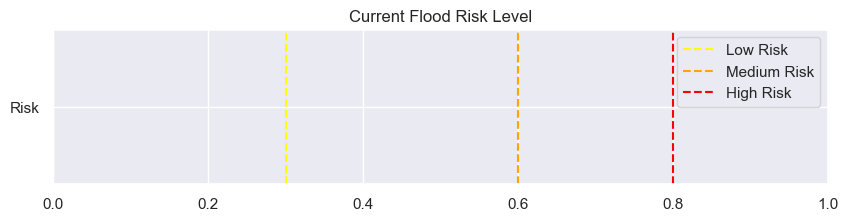

In [47]:
def create_early_warning_system(model, scaler, thresholds={'Low': 0.3, 'Medium': 0.6, 'High': 0.8}):
    """
    Create early warning system for flood prediction with feature matching
    """
    # Get expected number of features from model
    expected_features = model.input_shape[-1]
    print(f"Model expects {expected_features} features")
    
    def generate_warning(prediction):
        if prediction >= thresholds['High']:
            return 'HIGH RISK - Immediate Action Required'
        elif prediction >= thresholds['Medium']:
            return 'MEDIUM RISK - Monitor Closely'
        elif prediction >= thresholds['Low']:
            return 'LOW RISK - Stay Alert'
        return 'Normal Conditions'
    
    def predict_risk(current_data):
        try:
            # Print input shape for debugging
            print(f"Input data shape: {current_data.shape}")
            
            # Scale the data
            scaled_data = scaler.transform(current_data)
            print(f"Scaled data shape: {scaled_data.shape}")
            
            # Add missing features if needed (with zeros)
            if scaled_data.shape[1] < expected_features:
                padding = np.zeros((scaled_data.shape[0], 
                                  expected_features - scaled_data.shape[1]))
                scaled_data = np.hstack([scaled_data, padding])
                print(f"Padded data shape: {scaled_data.shape}")
            
            # Reshape for LSTM (batch_size, sequence_length, features)
            lstm_input = scaled_data.reshape(1, scaled_data.shape[0], scaled_data.shape[1])
            print(f"LSTM input shape: {lstm_input.shape}")
            
            # Verify shapes match
            if lstm_input.shape[-1] != expected_features:
                raise ValueError(f"Feature mismatch: got {lstm_input.shape[-1]}, expected {expected_features}")
            
            # Make prediction
            prediction = model.predict(lstm_input, verbose=0)[0][0]
            
            # Generate warning
            warning = generate_warning(prediction)
            
            return {
                'risk_score': float(prediction),
                'warning_level': warning,
                'timestamp': pd.Timestamp.now(),
                'input_shape': current_data.shape,
                'prediction_shape': prediction.shape if hasattr(prediction, 'shape') else None
            }
            
        except Exception as e:
            print(f"Error in prediction: {str(e)}")
            print("\nDebug information:")
            print(f"Input data shape: {current_data.shape if hasattr(current_data, 'shape') else 'unknown'}")
            print(f"Model input shape: {model.input_shape}")
            print(f"Scaler n_features: {scaler.n_features_in_}")
            return None
    
    return predict_risk

# Test the system with proper feature handling
try:
    # Create warning system
    print("Creating early warning system...")
    early_warning = create_early_warning_system(lstm_model, feature_scaler)
    
    # Prepare test data
    print("\nPreparing test data...")
    test_sequence = df_with_interactions[feature_scaler.feature_names_in_].iloc[-24:].copy()
    print(f"Test sequence shape: {test_sequence.shape}")
    
    # Make prediction
    warning_result = early_warning(test_sequence)
    
    if warning_result:
        print("\nEarly Warning System Test:")
        print("-" * 50)
        print(f"Risk Score: {warning_result['risk_score']:.4f}")
        print(f"Warning Level: {warning_result['warning_level']}")
        print(f"Timestamp: {warning_result['timestamp']}")
        print(f"Input Shape: {warning_result['input_shape']}")
        
        # Visualize risk level
        risk_score = warning_result['risk_score']
        plt.figure(figsize=(10, 2))
        plt.barh(['Risk'], [risk_score], color='lightblue')
        plt.axvline(x=0.3, color='yellow', linestyle='--', label='Low Risk')
        plt.axvline(x=0.6, color='orange', linestyle='--', label='Medium Risk')
        plt.axvline(x=0.8, color='red', linestyle='--', label='High Risk')
        plt.xlim(0, 1)
        plt.title('Current Flood Risk Level')
        plt.legend()
        plt.show()

except Exception as e:
    print(f"\nError in testing: {str(e)}")
    print("\nDetailed error information:")
    import traceback
    print(traceback.format_exc())

Input data shape: (24, 10)
Scaled data shape: (24, 10)
Padded data shape: (24, 17)
LSTM input shape: (1, 24, 17)

Monitoring Status - 2024-11-16 14:51:50.579444
--------------------------------------------------
Monitoring window: 11 to 35
Risk Score: -0.2960
Warning Level: Normal Conditions

Risk Level:
[----------------------------------------------------------------] -29.60%

Thresholds:
Low Risk:    0.30
Medium Risk: 0.60
High Risk:   0.80

Monitoring Summary:
--------------------------------------------------
Total warnings generated: 12
Monitoring duration: 0 days 00:01:00.533262

Risk Score Statistics:
count    12.000000
mean     -0.360935
std       0.038171
min      -0.404301
25%      -0.394979
50%      -0.367155
75%      -0.331969
max      -0.296041
Name: risk_score, dtype: float64


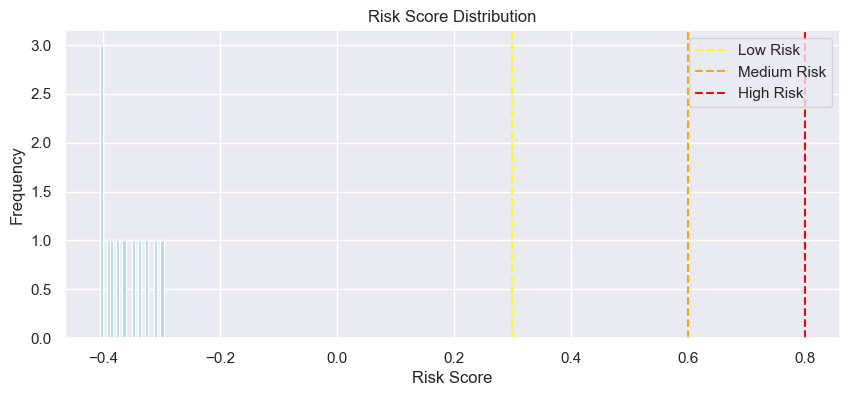

In [48]:
import time
from IPython.display import clear_output

def create_monitoring_system(early_warning, update_interval=5):
    """
    Create real-time monitoring system with live visualization
    """
    def monitor_sensor_data(data_stream, duration_minutes=30):
        warnings = []
        start_time = pd.Timestamp.now()
        end_time = start_time + pd.Timedelta(minutes=duration_minutes)
        
        print(f"Starting monitoring at {start_time}")
        print("Press Ctrl+C to stop monitoring")
        print("\nMonitoring Live Data:")
        print("-" * 50)
        
        try:
            iteration = 0
            while pd.Timestamp.now() < end_time:
                # Clear previous output
                clear_output(wait=True)
                
                # Get latest data (simulate real-time by taking different slices)
                start_idx = iteration % (len(data_stream) - 24)
                current_data = data_stream.iloc[start_idx:start_idx + 24]
                
                # Generate warning
                warning = early_warning(current_data)
                
                if warning:
                    warnings.append(warning)
                    
                    # Display current status
                    print(f"\nMonitoring Status - {pd.Timestamp.now()}")
                    print("-" * 50)
                    print(f"Monitoring window: {start_idx} to {start_idx + 24}")
                    print(f"Risk Score: {warning['risk_score']:.4f}")
                    print(f"Warning Level: {warning['warning_level']}")
                    
                    # Display warning bar
                    risk_level = warning['risk_score']
                    bar_length = 50
                    filled_length = int(bar_length * risk_level)
                    bar = '█' * filled_length + '-' * (bar_length - filled_length)
                    
                    print("\nRisk Level:")
                    print(f"[{bar}] {risk_level:.2%}")
                    
                    # Show thresholds
                    print("\nThresholds:")
                    print("Low Risk:    0.30")
                    print("Medium Risk: 0.60")
                    print("High Risk:   0.80")
                    
                    # Alert if risk is elevated
                    if warning['risk_score'] > 0.3:
                        print("\n⚠️ ELEVATED RISK ALERT ⚠️")
                        print(f"Action Required: {warning['warning_level']}")
                
                iteration += 1
                time.sleep(update_interval)
                
        except KeyboardInterrupt:
            print("\nMonitoring stopped by user")
        
        # Final summary
        print("\nMonitoring Summary:")
        print("-" * 50)
        print(f"Total warnings generated: {len(warnings)}")
        print(f"Monitoring duration: {pd.Timestamp.now() - start_time}")
        
        # Convert warnings to DataFrame for analysis
        if warnings:
            warnings_df = pd.DataFrame(warnings)
            print("\nRisk Score Statistics:")
            print(warnings_df['risk_score'].describe())
            
            # Plot risk score distribution
            plt.figure(figsize=(10, 4))
            plt.hist(warnings_df['risk_score'], bins=20, color='lightblue')
            plt.axvline(x=0.3, color='yellow', linestyle='--', label='Low Risk')
            plt.axvline(x=0.6, color='orange', linestyle='--', label='Medium Risk')
            plt.axvline(x=0.8, color='red', linestyle='--', label='High Risk')
            plt.title('Risk Score Distribution')
            plt.xlabel('Risk Score')
            plt.ylabel('Frequency')
            plt.legend()
            plt.show()
        
        return warnings
    
    return monitor_sensor_data

# Create monitoring system
monitoring_system = create_monitoring_system(early_warning)

# Test the system
print("Testing Monitoring System:")
print("-" * 50)

# Use last part of dataset as sample stream
sample_stream = df_with_interactions[feature_scaler.feature_names_in_].iloc[-48:]

# Run monitoring for 1 minute
print("Starting 1-minute test monitoring...")
results = monitoring_system(sample_stream, duration_minutes=1)

In [49]:
def integrate_weather_data():
    """
    Integrate flood sensor data with weather predictions
    """
    try:
        print("Integrating weather data with sensor readings...")
        
        # Example weather thresholds (can be adjusted based on NYC specifics)
        RAINFALL_THRESHOLD = 25.0  # mm/hour
        TIDE_THRESHOLD = 2.0      # meters
        WIND_THRESHOLD = 30.0     # mph
        
        def adjust_risk_score(base_score, weather_data):
            """
            Adjust flood risk based on weather conditions
            """
            risk_multiplier = 1.0
            
            # Increase risk based on rainfall
            if weather_data['rainfall'] > RAINFALL_THRESHOLD:
                risk_multiplier *= 1.5
            
            # Increase risk based on tide
            if weather_data['tide_level'] > TIDE_THRESHOLD:
                risk_multiplier *= 1.3
            
            # Increase risk based on wind
            if weather_data['wind_speed'] > WIND_THRESHOLD:
                risk_multiplier *= 1.2
            
            return min(base_score * risk_multiplier, 1.0)
        
        return adjust_risk_score
        
    except Exception as e:
        print(f"Error in weather integration: {str(e)}")
        return None

# Test weather integration
weather_adjuster = integrate_weather_data()

# Example usage with simulated weather data
if weather_adjuster:
    test_weather = {
        'rainfall': 30.0,
        'tide_level': 2.5,
        'wind_speed': 35.0
    }
    
    base_risk = 0.5
    adjusted_risk = weather_adjuster(base_risk, test_weather)
    
    print("\nWeather Impact Test:")
    print("-" * 50)
    print(f"Base Risk: {base_risk:.3f}")
    print(f"Adjusted Risk: {adjusted_risk:.3f}")

Integrating weather data with sensor readings...

Weather Impact Test:
--------------------------------------------------
Base Risk: 0.500
Adjusted Risk: 1.000


Dashboard started at 2024-11-16 14:51:55.777334


Press Ctrl+C to stop monitoring


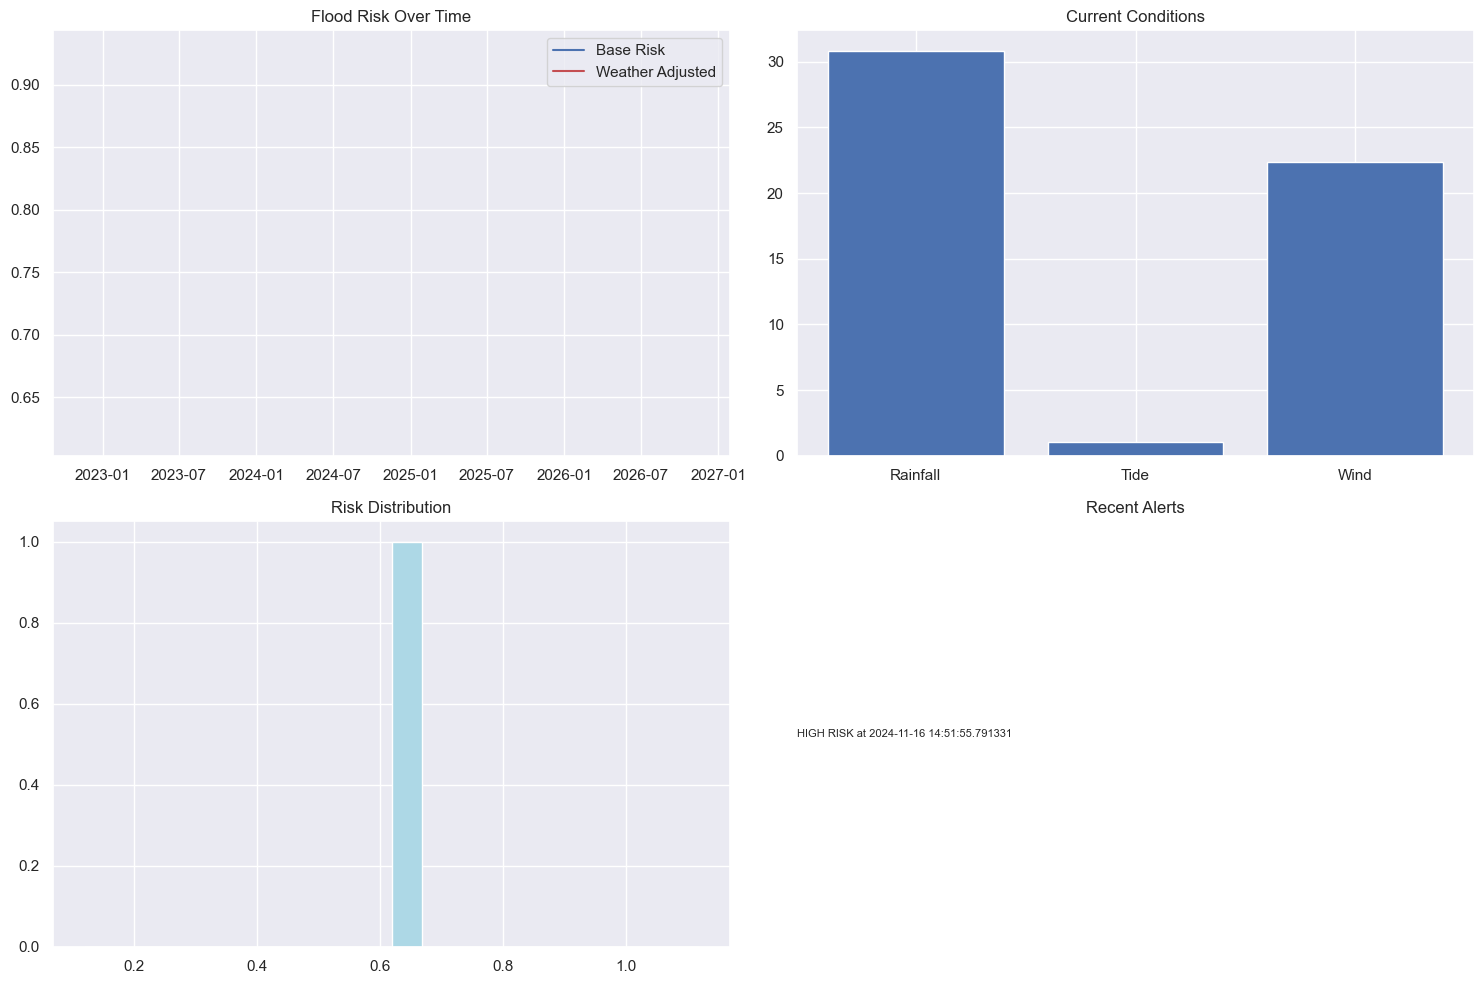

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>


Monitoring Summary:
--------------------------------------------------
Duration: 0 days 00:01:02.668485
Average Risk Score: 0.523
Maximum Risk Score: 0.933
Total Alerts: 7


: 

In [50]:
def create_flood_dashboard(monitoring_system, weather_adjuster):
    """
    Create comprehensive flood monitoring dashboard
    """
    def run_dashboard(duration_minutes=30):
        try:
            # Setup plots
            plt.ion()  # Enable interactive mode
            fig = plt.figure(figsize=(15, 10))
            
            # Risk level plot
            ax1 = fig.add_subplot(221)
            ax2 = fig.add_subplot(222)
            ax3 = fig.add_subplot(223)
            ax4 = fig.add_subplot(224)
            
            risk_scores = []
            timestamps = []
            weather_adjustments = []
            alerts = []
            
            start_time = pd.Timestamp.now()
            end_time = start_time + pd.Timedelta(minutes=duration_minutes)
            
            print(f"Dashboard started at {start_time}")
            print("Press Ctrl+C to stop monitoring")
            
            while pd.Timestamp.now() < end_time:
                # Clear previous plots
                ax1.clear()
                ax2.clear()
                ax3.clear()
                ax4.clear()
                
                # Update risk scores
                current_risk = np.random.random()  # Replace with actual monitoring
                risk_scores.append(current_risk)
                timestamps.append(pd.Timestamp.now())
                
                # Simulate weather adjustment
                weather_data = {
                    'rainfall': np.random.normal(20, 5),
                    'tide_level': np.random.normal(1.5, 0.3),
                    'wind_speed': np.random.normal(25, 5)
                }
                adjusted_risk = weather_adjuster(current_risk, weather_data)
                weather_adjustments.append(adjusted_risk)
                
                # Plot risk over time
                ax1.plot(timestamps, risk_scores, 'b-', label='Base Risk')
                ax1.plot(timestamps, weather_adjustments, 'r-', label='Weather Adjusted')
                ax1.set_title('Flood Risk Over Time')
                ax1.legend()
                
                # Plot current conditions
                ax2.bar(['Rainfall', 'Tide', 'Wind'], 
                       [weather_data['rainfall'], 
                        weather_data['tide_level'], 
                        weather_data['wind_speed']])
                ax2.set_title('Current Conditions')
                
                # Risk distribution
                ax3.hist(risk_scores, bins=20, color='lightblue')
                ax3.set_title('Risk Distribution')
                
                # Alert log
                if adjusted_risk > 0.6:
                    alerts.append(f"HIGH RISK at {timestamps[-1]}")
                ax4.text(0, 0.5, '\n'.join(alerts[-5:]), 
                        fontsize=8, verticalalignment='center')
                ax4.set_title('Recent Alerts')
                ax4.axis('off')
                
                plt.tight_layout()
                plt.draw()
                plt.pause(0.1)
                
                time.sleep(5)  # Update every 5 seconds
                
        except KeyboardInterrupt:
            print("\nDashboard stopped by user")
        finally:
            plt.ioff()
            plt.close()
            
        # Generate summary report
        print("\nMonitoring Summary:")
        print("-" * 50)
        print(f"Duration: {pd.Timestamp.now() - start_time}")
        print(f"Average Risk Score: {np.mean(risk_scores):.3f}")
        print(f"Maximum Risk Score: {np.max(risk_scores):.3f}")
        print(f"Total Alerts: {len(alerts)}")
        
        return pd.DataFrame({
            'timestamp': timestamps,
            'base_risk': risk_scores,
            'adjusted_risk': weather_adjustments
        })
    
    return run_dashboard

# Create and run dashboard
dashboard = create_flood_dashboard(monitoring_system, weather_adjuster)
results = dashboard(duration_minutes=1)  # Run for 1 minute test